# Spaceship Titanic

- 세번째 시도
    - Tfdf decision_forest에서 지원하는 모델 모두 써보기

## Import Modules

In [1]:
import os
import sys
from datetime import datetime
from zipfile import ZipFile
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow as tf
import tensorflow_decision_forests as tfdf

2023-12-16 13:09:26.163431: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-16 13:09:26.187129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 13:09:26.187153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 13:09:26.187665: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 13:09:26.193361: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.config.list_physical_devices()

2023-12-16 13:09:27.296589: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 13:09:27.318301: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 13:09:27.318361: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3153962746801611636
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9816768512
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3813432587289507484
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

2023-12-16 13:09:27.339000: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 13:09:27.339099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 13:09:27.339129: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 13:09:28.327636: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 13:09:28.327704: I external/local_xla/xla/stream_executor

## Set envs

In [4]:
PATH_INPUT = './data/in/'
PATH_OUTPUT = './data/out/'
NOW_STR = datetime.now().strftime('%Y%m%d_%H%M%S')
PATH_OUTPUT_NOW = f'./data/out/{NOW_STR}/'

try:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    gpus = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)]
    )
except:
    print("NO GPU")

## Check Data

### Get Data

In [5]:
with ZipFile(PATH_INPUT + 'spaceship-titanic.zip') as f:
    print(f.namelist())

    df_train = pd.read_csv(BytesIO(f.read('train.csv')))
    df_test = pd.read_csv(BytesIO(f.read('test.csv')))
    df_sample = pd.read_csv(BytesIO(f.read('sample_submission.csv')))

['sample_submission.csv', 'test.csv', 'train.csv']


### Print Data

In [6]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [8]:
df_sample.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


## Data Preprocessing

In [9]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


### Delete Null Data

In [11]:
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

- HomePlanet,CryoSleep,Cabin,Destination,VIP: null -> delete

In [12]:
df_train.dropna(subset=['HomePlanet','CryoSleep','Cabin','Destination','VIP'], inplace=True)

- Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck: null -> most frequency

In [13]:
columns = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for col in columns:
    most_freq = df_train[col].mode()[0]
    df_train[col].fillna(value=most_freq, inplace=True)

In [14]:
df_train.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            177
Transported       0
dtype: int64

### Data Bias

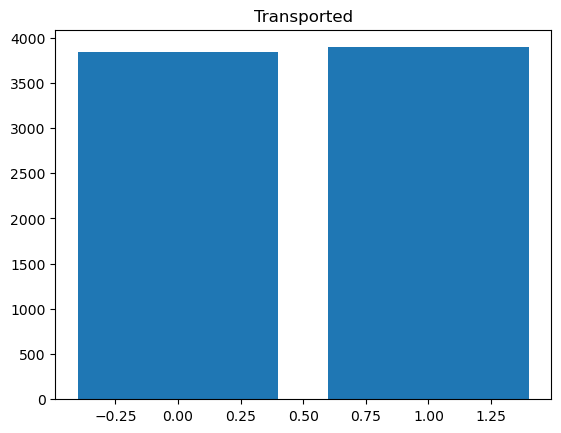

In [15]:
x = df_train['Transported'].unique()
y = [ len(df_train[df_train['Transported'] == i]) for i in x ]
plt.title('Transported')
plt.bar(x,y)
plt.show()

/home/momo/anaconda3/envs/tfgpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/momo/anaconda3/envs/tfgpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/momo/anaconda3/envs/tfgpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/momo/anaconda3/envs/tfgpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

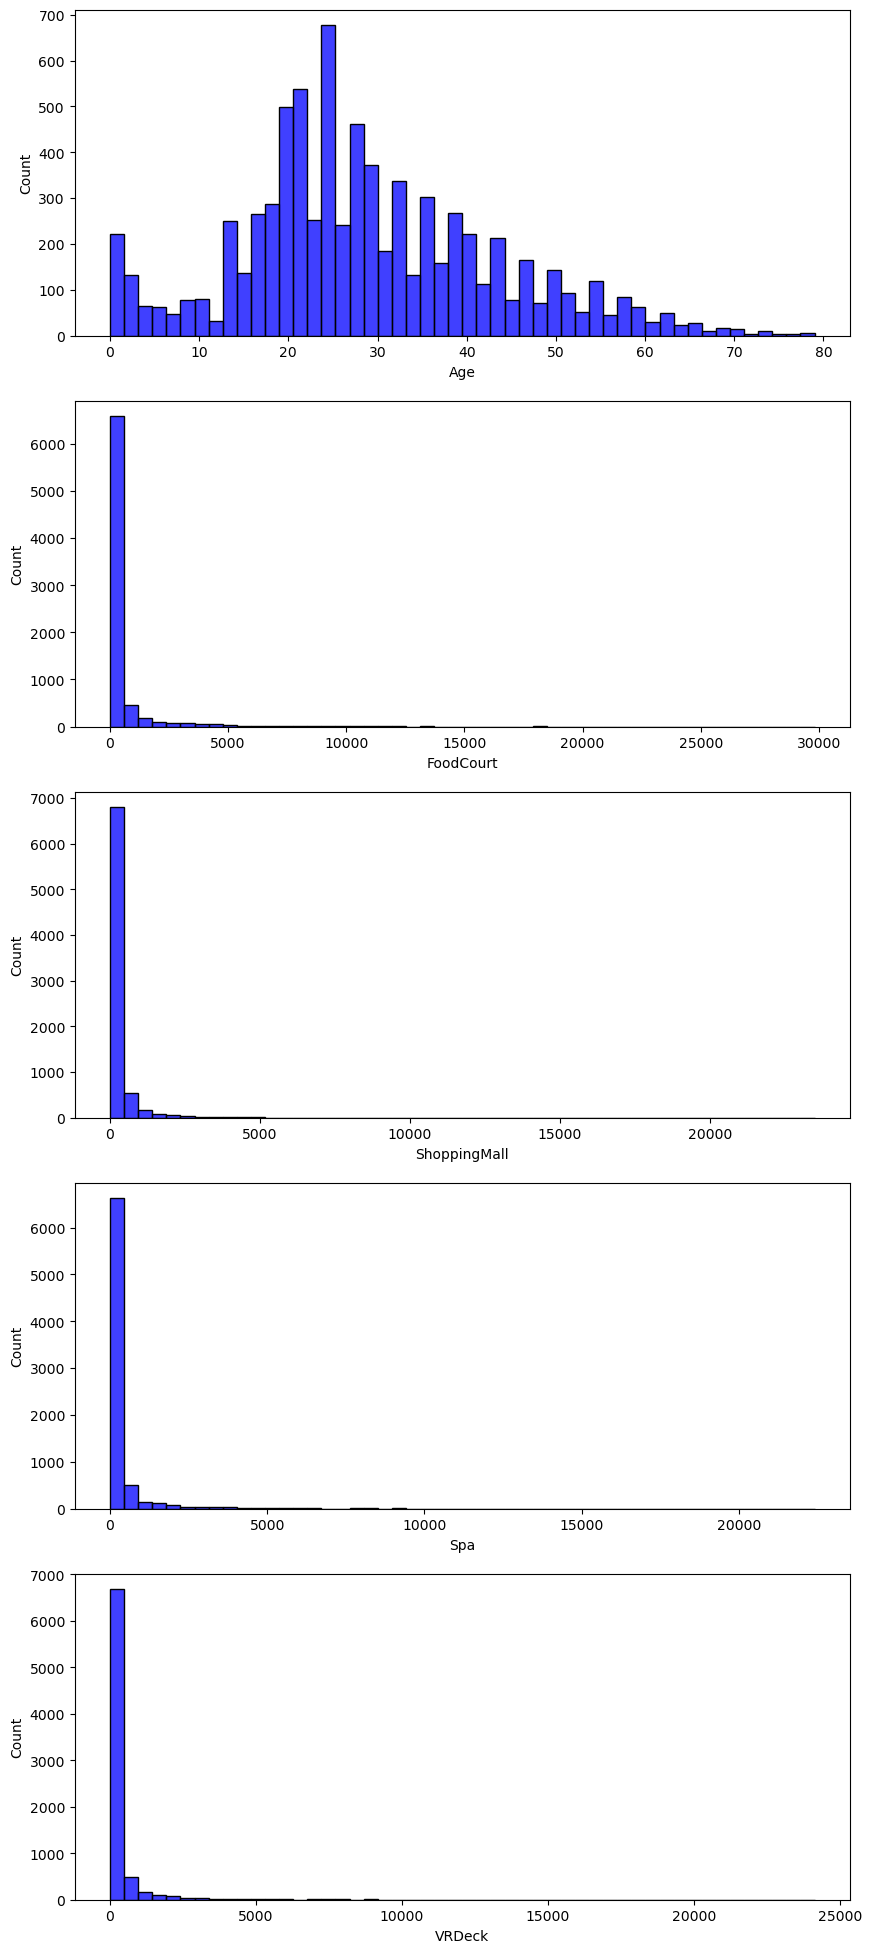

In [16]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(df_train['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(df_train['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(df_train['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(df_train['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(df_train['VRDeck'], color='b', bins=50, ax=ax[4]);

### String Data

In [17]:
non_num = ['HomePlanet', 'Cabin', 'Destination']
for col in non_num:
    uniq = df_train[col].unique()
    print("{0:=^40}".format(col))
    print(f'{uniq}  ({len(uniq)})')

===============HomePlanet===============
['Europa' 'Earth' 'Mars']  (3)
=================Cabin==================
['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']  (6068)
==============Destination===============
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']  (3)


-> HomePlanet, Destination : One-hot Encoding

In [18]:
df_train = pd.get_dummies(df_train, columns=['HomePlanet', 'Destination'], dtype=int)

-> CryoSleep, VIP, Transported: Label Encoding (True: 1, False: 0)

In [19]:
df_train["CryoSleep"] = df_train["CryoSleep"].astype(int)
df_train["VIP"] = df_train["VIP"].astype(int)
df_train["Transported"] = df_train["Transported"].astype(int)

-> Cabin: split to "Deck", "Cabin_num", "Side"

In [20]:
df_train[["Deck", "Cabin_num", "Side"]] = df_train["Cabin"].str.split("/", expand=True)
df_train.drop("Cabin", axis=1, inplace=True)

In [21]:
df_train

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck,Cabin_num,Side
0,0001_01,0,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,1,0,0,0,1,B,0,P
1,0002_01,0,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,1,0,0,0,0,1,F,0,S
2,0003_01,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,1,0,0,0,1,A,0,S
3,0003_02,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0,1,0,0,0,1,A,0,S
4,0004_01,0,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1,0,0,0,0,1,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,0,1,0,1,0,0,A,98,P
8689,9278_01,1,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,1,0,0,0,1,0,G,1499,S
8690,9279_01,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,1,0,0,0,0,1,G,1500,S
8691,9280_01,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,0,1,0,1,0,0,E,608,S


## Train

### Set Input data

In [22]:
exception_cols = ['PassengerId', 'Name']
independents = [ i for i in df_train.keys() if i not in exception_cols ]
# 'CryoSleep', 'Cabin', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e'

X = df_train[independents]

X_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(X, label="Transported")

2023-12-16 13:09:29.588147: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 13:09:29.588259: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 13:09:29.588296: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 13:09:29.588344: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 13:09:29.588349: I tensorflow/core/common_runtime/gpu/gpu

In [23]:
independents

['CryoSleep',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Transported',
 'HomePlanet_Earth',
 'HomePlanet_Europa',
 'HomePlanet_Mars',
 'Destination_55 Cancri e',
 'Destination_PSO J318.5-22',
 'Destination_TRAPPIST-1e',
 'Deck',
 'Cabin_num',
 'Side']

In [24]:
X.shape

(7736, 18)

### Check available all models

In [25]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

### Definition Function Using,Fitting,Predicting models

In [26]:
def process_model(model, model_name):
    global df_test, X_tf_dataset, X_test_tf_dataset
    global independents

    print(f'{model_name} 학습 시작')
    
    # build
    model.compile(metrics=['accuray'])

    # fit
    model.fit(X_tf_dataset, verbose=1)

    # visualize
    path_out_plot = os.path.join(PATH_OUTPUT_NOW, "monitor")
    if not os.path.exists(path_out_plot):
        os.makedirs(path_out_plot)

    path_out_plot = os.path.join(path_out_plot, f"{model_name}_model_plot.html")

    # vscode - jupyter 경우 사진이 안보임 -> 로컬에 저장. Colab일 경우 보여줌
    if 'vscode' in os.environ['PATH'] and 'google.colab' not in list(sys.modules.keys()):
        with open(path_out_plot, "w") as f:
            f.write(tfdf.model_plotter.plot_model(model, tree_idx=0, max_depth=3))
    else:
        tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

    # validation
    # logs
    logs = model.make_inspector().training_logs()
    if logs is not None:
        plt.plot([ log.num_trees for log in logs ], [ log.evaluation.accuracy for log in logs ])
        plt.xlabel("Number of Trees")
        plt.ylabel("Accuracy (out-of-bag)")
        plt.show()

    inspector = model.make_inspector()
    inspector.evaluation()

    print(f"Available variable importances: {inspector.variable_importances().keys()}")

    print(inspector.variable_importances()["NUM_AS_ROOT"])

    # save model
    if not os.path.exists(os.path.join(PATH_OUTPUT_NOW, "models")):
        os.makedirs(os.path.join(PATH_OUTPUT_NOW, "models"))
    with open(os.path.join(PATH_OUTPUT_NOW, "models", f"model_{model_name}.pkl"), "wb") as f:
        pickle.dump(model, f)

    # predict
    predictions = model.predict(X_test_tf_dataset)
    predictions = map(lambda v: True if v[0] > 0.5 else False, predictions)
    predictions = list(predictions)

    # Export predictions to csv file
    output = pd.DataFrame({ "PassengerId": df_test['PassengerId'].to_list(), "Transported": predictions })
    output_dir = os.path.join(PATH_OUTPUT_NOW, "predict")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    output.to_csv(os.path.join(output_dir, f'predict_tfdf_{model_name}.csv'), index=False)

### preprocess test data

In [27]:
# - fill null datas
columns = ['HomePlanet','CryoSleep','Cabin','Destination','VIP','Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for col in columns:
    df_test[col].fillna(value=0, inplace=True)

# - HomePlanet, Destination: One-hot Encoding
df_test = pd.get_dummies(df_test, columns=['HomePlanet', 'Destination'], dtype=int)

# - CryoSleep, VIP, Transported: Label Encoding (True: 1, False: 0)
df_test["CryoSleep"] = df_test["CryoSleep"].map(lambda v: 1 if v else 0)
df_test["VIP"] = df_test["VIP"].map(lambda v: 1 if v else 0)

# - Cabin: split to "Deck", "Cabin_num", "Side"
df_test[["Deck", "Cabin_num", "Side"]] = df_test["Cabin"].str.split("/", expand=True)
df_test.drop("Cabin", axis=1, inplace=True)

In [28]:
# change dataframe to tf_dataset
independents = [i for i in independents if i != 'Transported']
X_test = df_test[independents]
X_test_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(X_test)

In [29]:
df_test.isnull().sum()

PassengerId                    0
CryoSleep                      0
Age                            0
VIP                            0
RoomService                    0
FoodCourt                      0
ShoppingMall                   0
Spa                            0
VRDeck                         0
Name                          94
HomePlanet_0                   0
HomePlanet_Earth               0
HomePlanet_Europa              0
HomePlanet_Mars                0
Destination_0                  0
Destination_55 Cancri e        0
Destination_PSO J318.5-22      0
Destination_TRAPPIST-1e        0
Deck                         100
Cabin_num                    100
Side                         100
dtype: int64

### Use above function

Use /tmp/tmpyq14cljx as temporary training directory
RandomForestModel 학습 시작
Reading training dataset...
Training dataset read in 0:00:02.633794. Found 7736 examples.
Training model...


[INFO 23-12-16 13:09:40.7757 KST kernel.cc:1233] Loading model from path /tmp/tmpyq14cljx/model/ with prefix 6fda52285a684986


Model trained in 0:00:07.973628
Compiling model...


[INFO 23-12-16 13:09:41.1031 KST decision_forest.cc:660] Model loaded with 300 root(s), 256182 node(s), and 17 input feature(s).
[INFO 23-12-16 13:09:41.1031 KST abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 23-12-16 13:09:41.1031 KST kernel.cc:1061] Use fast generic engine


Model compiled.


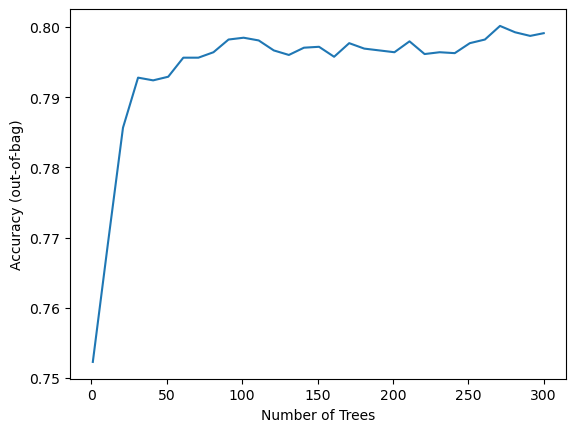

Available variable importances: dict_keys(['NUM_AS_ROOT', 'INV_MEAN_MIN_DEPTH', 'NUM_NODES', 'SUM_SCORE'])
[("CryoSleep" (1; #2), 94.0), ("RoomService" (1; #11), 67.0), ("Spa" (1; #14), 55.0), ("VRDeck" (1; #16), 34.0), ("ShoppingMall" (1; #12), 21.0), ("FoodCourt" (1; #7), 13.0), ("Deck" (4; #3), 9.0), ("HomePlanet_Earth" (1; #8), 3.0), ("HomePlanet_Europa" (1; #9), 3.0), ("Destination_55_Cancri_e" (1; #4), 1.0)]
5/5 [==============================] - 0s 41ms/step
Use /tmp/tmp590nz1aj as temporary training directory
GradientBoostedTreesModel 학습 시작
Reading training dataset...


[WARNING 23-12-16 13:09:42.5829 KST gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-12-16 13:09:42.5829 KST gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-12-16 13:09:42.5829 KST gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231724. Found 7736 examples.
Training model...
Model trained in 0:00:15.101717
Compiling model...
Model compiled.


[INFO 23-12-16 13:09:57.9245 KST kernel.cc:1233] Loading model from path /tmp/tmp590nz1aj/model/ with prefix 5a87e4f2f334444c
[INFO 23-12-16 13:09:57.9264 KST quick_scorer_extended.cc:903] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 23-12-16 13:09:57.9273 KST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-12-16 13:09:57.9273 KST kernel.cc:1061] Use fast generic engine


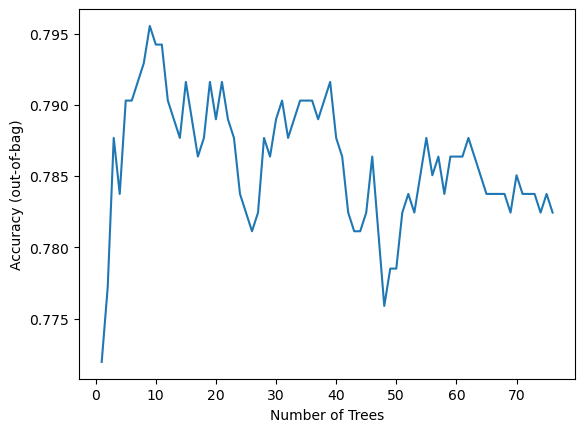

Available variable importances: dict_keys(['NUM_NODES', 'SUM_SCORE', 'NUM_AS_ROOT', 'INV_MEAN_MIN_DEPTH'])
[("CryoSleep" (1; #2), 22.0), ("Spa" (1; #14), 13.0), ("VRDeck" (1; #16), 6.0), ("Side" (4; #13), 4.0), ("Age" (1; #0), 1.0)]
5/5 [==============================] - 0s 12ms/step
Use /tmp/tmp6z7fwox3 as temporary training directory
CartModel 학습 시작
Reading training dataset...
Training dataset read in 0:00:00.203180. Found 7736 examples.
Training model...
Model trained in 0:00:00.299475
Compiling model...
Model compiled.


[INFO 23-12-16 13:09:58.8519 KST kernel.cc:1233] Loading model from path /tmp/tmp6z7fwox3/model/ with prefix 9be6e8bc36d7489f
[INFO 23-12-16 13:09:58.8523 KST decision_forest.cc:660] Model loaded with 1 root(s), 179 node(s), and 13 input feature(s).
[INFO 23-12-16 13:09:58.8523 KST kernel.cc:1061] Use fast generic engine


Available variable importances: dict_keys(['NUM_AS_ROOT', 'SUM_SCORE', 'NUM_NODES', 'INV_MEAN_MIN_DEPTH'])
[("CryoSleep" (1; #2), 1.0)]


5/5 [==============================] - 0s 8ms/step


In [30]:
all_models = tfdf.keras.get_all_models()

for modelClass in [m for m in all_models if m.__name__ != 'DistributedGradientBoostedTreesModel']:
    model = modelClass(verbose=1)
    process_model(model, modelClass.__name__)